# Datenanlyse zur Umfrage Persönliche Expertise

---

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns



## Import data from csv

In [2]:
filename = 'data/export_0907.csv'
df = pd.read_csv(filename, sep=';')

In [3]:
df.head()

,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,c_0002,c_0003,...,rnd_pg_7356560_3,rnd_pg_7356560_4,rnd_pg_7356560_5,rnd_pg_7356560_6,rnd_pg_7356570_1,rnd_pg_7356570_2,rnd_pg_7356570_3,rnd_pg_7356570_4,rnd_pg_7356570_5,rnd_pg_7356570_6
0,176,0,0,31,7356546,-77,783,3,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
1,178,0,0,31,7356546,-77,1691,2,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
2,181,0,0,31,7356546,-77,865,-66,1,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
3,182,0,0,31,7356546,-77,536,-66,2,-66,...,7356565,7356566,7356563,7356561,-77,-77,-77,-77,-77,-77
4,184,0,0,31,7356546,-77,680,1,-66,970,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77


In [4]:
df['priming'] = df['c_0001'].replace(-66, np.nan).fillna(df['c_0002']).astype(int)


In [5]:
def classify_professional(row):
    # Check if any CVPA score is less than 2
    cvpa_columns = ['v_8978', 'v_9154', 'v_9155', 'v_9156', 'v_9157', 'v_9158', 'v_9159', 'v_9160', 'v_9308']
    for col in cvpa_columns:
        if row[col] < 2:
            return False
    
    # Check if sum of CVPA scores is less than 34
    cvpa_sum = sum(row[col] for col in cvpa_columns)
    if cvpa_sum < 34:
        return False
    
    # Count correct answers for knowledge questions
    correct_answers = 0
    knowledge_answers = {
        'v_206': 3,
        'v_207': 3,
        'v_208': 2,
        'v_209': 2,
        'v_210': 3,
        'v_211': 3,
        'v_212': 2,
        'v_213': 4,
        'v_214': 1,
        'v_215': 3
    }
    
    for col, correct_value in knowledge_answers.items():
        if col in row and row[col] == correct_value:
            correct_answers += 1
    
    # Check if correct answers is less than 6
    if correct_answers < 6:
        return False
    
    return True

# Apply the classification function to create a new column
df['is_professional'] = df.apply(classify_professional, axis=1)

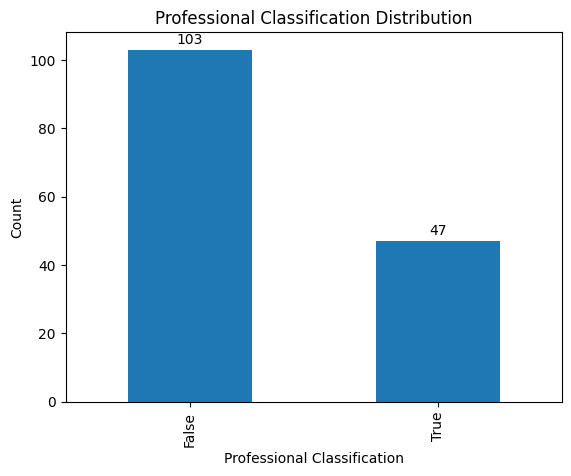

In [6]:
counts = df['is_professional'].value_counts()
ax = counts.plot(kind='bar', title='Professional Classification Distribution')
ax.set_xlabel('Professional Classification')
ax.set_ylabel('Count')

# Add value labels on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

## Forschungsfrage
- Hat die persönliche Expertise von
Konsument:innen einen Einfluss auf
Präferenzen und Preiserwartungen von
stilistisch konsistenten und
inkonsistenten Produktensembles.

## Hypothesen

### Hypothesen zu Präferenzen:
**H0₁:** Persönliche Expertise hat **keinen** Einfluss auf die Präferenzen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten = μ_Nicht-Experten (bezüglich Präferenzwerten)

**H1₁:** Persönliche Expertise hat einen **signifikanten** Einfluss auf die Präferenzen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten ≠ μ_Nicht-Experten (bezüglich Präferenzwerten)

### Hypothesen zu Preiserwartungen:
**H0₂:** Persönliche Expertise hat **keinen** Einfluss auf die Preiserwartungen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten = μ_Nicht-Experten (bezüglich Preiserwartungen)

**H1₂:** Persönliche Expertise hat einen **signifikanten** Einfluss auf die Preiserwartungen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten ≠ μ_Nicht-Experten (bezüglich Preiserwartungen)

### Statistische Tests:
- **Unabhängige t-Tests** für Mittelwertvergleiche zwischen Experten (`is_professional = True`) und Nicht-Experten (`is_professional = False`)
- **Signifikanzniveau:** α = 0.05
- **Zweiseitige Tests** (da keine gerichtete Hypothese vorliegt)

## Variablen
### Abhängige Variablen (AV)

- **Preiserwartung**  
  Für welchen Preis würden Sie erwarten, dass das Produkt/Ensemble angeboten wird? (metrisch)  
  - einzeln  
  - ensemble  
  - korrektur ensemble

- **Objektive Einzelbewertung (Liking)**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Einzelbewertung (Liking)**  
  - Das Produkt gefällt mir gut. (Likert-Skala)  
  - Ich mag das Produkt. (Likert-Skala)  
  - Ich finde das Produkt ansprechend. (Likert-Skala)

- **Objektive Ensemble-Bewertung**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Ensemble-Bewertung**  
  - Das Ensemble gefällt mir gut. (Likert-Skala)  
  - Ich mag das Ensemble. (Likert-Skala)  
  - Ich finde das Ensemble ansprechend. (Likert-Skala)

- **Produktdarstellung**  
  - Die Kombination vermittelt mir relevante Informationen über die Produkte. (Likert-Skala)  
  - Die gezeigte Zusammenstellung hilft mir, die Produkte besser zu verstehen. (Likert-Skala)  
  - Die Präsentation erleichtert es mir, die Produkte zu beurteilen. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, welche Personen dieses Outfit tragen würden. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, in welchen beruflichen Situationen das Outfit getragen wird. (Likert-Skala)  
  - Ich verstehe, wie man die Teile elegant, seriös und professionell kombiniert. (Likert-Skala)

- **Bewertungsleichtigkeit**  
  - Es fällt mir leicht, das Outfit zu bewerten. (Likert-Skala)  
  - Ich erfasse das Outfit visuell schnell. (Likert-Skala)  
  - Ich kann mir das Outfit mit geschlossenen Augen in Erinnerung rufen. (Likert-Skala)  
  - Ich kann das Outfit später einer anderen Person beschreiben. (Likert-Skala)

- **Gesamtwirkung**  
  - uneinheitlich ↔ einheitlich (Likert-Skala)  
  - unstimmig ↔ stimmig (Likert-Skala)  
  - unharmonisch ↔ harmonisch (Likert-Skala)

- **Stileinordnung**  
  - Hippie (Likert-Skala)  
  - Hip Hop / Active Wear (Likert-Skala)  
  - Boho (Likert-Skala)

---

### Unabhängige Variablen (UV)


- **Priming-Konsistenz**  
  - konsistentes Ensemble  
  - inkonsistentes Ensemble  
  - inkonsistentes Ensemble mit nichtansprechendem Oberteil

- **Stilrichtung**  
  - Hippie × Minimalistisch

- **Produktkategorie**  
  - Oberteil

- **Expertenstatus**  
  - Experte vs. Nicht-Experte (gemäß Faktenwissen & CVPA)

> **Design:** 3 × 2-Faktor (Priming-Konsistenz × Expertenstatus), between-subjects

---

### Kontroll- und Störvariablen

- **Demografische Variablen**  
  - Alter (metrisch, Jahre)  
  - Geschlecht (nominal, z. B. m/w/d)  
  - Einkommen (metrisch oder ordinal gruppiert)  
  - Bildungsgrad (ordinal)  
  - Beruf (nominal)

- **Berufserfahrung**  
  - (metrisch, Jahre)

- **CVPA-Score**  
  - (metrisch)

- **Faktenwissen-Score**  
  - (metrisch)


## Überprüfung der Hypothesen

---

### Hypothese 1 (Präferenzwerte)
- **Hypothese:**  
  - H₀₁: μ$_{Experten}$ = μ$_{NOT-Experten}$
  - H₁₁: μ$_{Experten}$ ≠ μ$_{NOT-Experten}$
- **Variable:**  
  - ΔLiking = Liking $_{konsistent}$ – Liking $_{inkonsistent}$
- **Methode:**  
  - **Unabhängiger t-Test** (zweiseitig)  
    - *Warum:* Vergleich von Mittelwerten zweier unabhängiger Gruppen bei intervallskaliertem DV  
- **Voraussetzungen prüfen:**  
  - **Normalverteilung** der ΔLiking in beiden Gruppen (Shapiro-Wilk-Test)
  - **Varianzhomogenität** (Levene-Test)  
- **Alternative bei Verletzung:**  
  - **Mann-Whitney-U-Test** (zweiseitig)  
    - *Warum:* Kein parametrischer Test, robust gegen Normalitätsverletzung  
- **Effektstärke:**  
  - Cohen’s d (t-Test) oder Rang-Biseriale Korrelation (Mann-Whitney)

---

### Hypothese 2 (Preiserwartungen)
- **Hypothese:**  
  - H₀₂: μ$_{Experten}$ = μ$_{NOT-Experten}$
  - H₁₂: μ$_{Experten}$ ≠ μ$_{NOT-Experten}$
- **Variable:**  
  - ΔPreis = Preiserwartung $_{konsistent}$ – Preiserwartung $_{inkonsistent}$
- **Statistisches Mittel & Vorgehen:**  
  - Analog zu Hypothese 1 (t-Test, Voraussetzungen, Alternative, Effektstärke)

---

### Signifikanz & Bericht
- **α = 0,05** (zweiseitig)  
- **Bericht:**  
  - Teststatistik (t-Wert bzw. U-Wert), p-Wert, Effektstärke  
  - Überprüfung der Testvoraussetzungen dokumentieren  


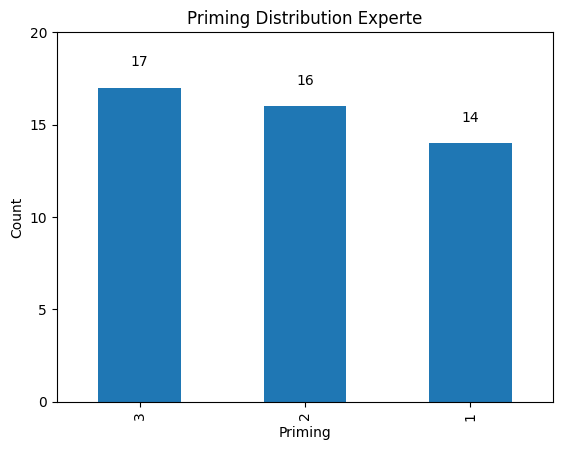

In [7]:
# Distribution of priming levels
filtered_rows = df[df['is_professional']].copy()
priming_counts = filtered_rows['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution Experte')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

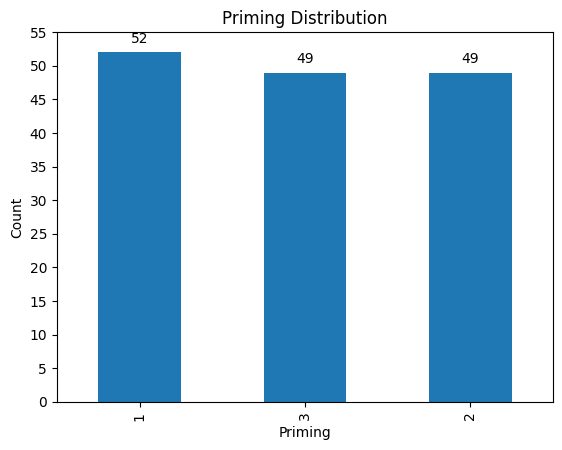

In [8]:
# Alternative priming distribution (column c_0002 replaced)
# Using combined 'priming' column instead
priming_counts = df['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

In [9]:
rename_map = dict()
inverse_map = dict()
def reduce_columns(row):
    # Get all columns that start with 'v_'
    v_columns = [col for col in row.index if col.startswith('v_')]

    # Filter out columns that have negative values
    valid_columns = ['priming', 'is_professional']  # Always include these columns
    counter = 0
    for col in v_columns:
        try:
            if int(row[col]) >= 0:
                valid_columns.append(col)
                counter += 1
                if f"Q{counter}" not in rename_map:
                    rename_map[f"Q{counter}"] = col
                else:
                    rename_map[f"Q{counter}"] += col
                
                if col not in inverse_map:
                    inverse_map[col] = f"Q{counter}"
                else:
                    inverse_map[col] = f"Q{counter}"
        except ValueError:
            # If conversion to int fails, skip this column
            continue
    
    # Create the result series with renamed columns
    result = {}
    for col in valid_columns:
        if col in inverse_map:
            # Use the Q-column name from inverse_map
            result[inverse_map[col]] = row[col]
        else:
            # Keep original column name for non-v columns
            result[col] = row[col]
    
    return pd.Series(result)
    


combined_df = df.apply(reduce_columns, axis=1)
combined_df.head()

,priming,is_professional,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q97,Q98,Q99
0,3,True,2,0,0,0,0,0,0,0,...,5,4,3,4,3,2,51,1,2,4
1,2,True,1,1,1,0,1,0,0,0,...,5,5,4,5,1,1,47,1,2,4
2,1,False,2,0,0,0,0,0,0,0,...,5,5,4,4,2,2,60,2,2,5
3,2,False,2,0,0,0,0,0,0,0,...,5,5,5,4,1,1,22,1,1,1
4,1,True,2,0,0,0,1,0,0,0,...,4,5,4,4,1,3,19,1,1,3


In [10]:
inverse_map

{'v_216': 'Q1',
 'v_218': 'Q2',
 'v_219': 'Q3',
 'v_220': 'Q4',
 'v_221': 'Q5',
 'v_222': 'Q6',
 'v_223': 'Q7',
 'v_224': 'Q8',
 'v_225': 'Q9',
 'v_226': 'Q10',
 'v_228': 'Q11',
 'v_206': 'Q12',
 'v_207': 'Q13',
 'v_208': 'Q14',
 'v_209': 'Q15',
 'v_210': 'Q16',
 'v_211': 'Q17',
 'v_212': 'Q18',
 'v_213': 'Q19',
 'v_214': 'Q20',
 'v_215': 'Q21',
 'v_8978': 'Q22',
 'v_9154': 'Q23',
 'v_9155': 'Q24',
 'v_9156': 'Q25',
 'v_9157': 'Q26',
 'v_9158': 'Q27',
 'v_9159': 'Q28',
 'v_9160': 'Q29',
 'v_9308': 'Q30',
 'v_11044': 'Q31',
 'v_11045': 'Q32',
 'v_11046': 'Q33',
 'v_11047': 'Q34',
 'v_11048': 'Q35',
 'v_11049': 'Q36',
 'v_11050': 'Q37',
 'v_11053': 'Q38',
 'v_11054': 'Q39',
 'v_11055': 'Q40',
 'v_11056': 'Q41',
 'v_11057': 'Q42',
 'v_11058': 'Q43',
 'v_11059': 'Q44',
 'v_11062': 'Q45',
 'v_11063': 'Q46',
 'v_11064': 'Q47',
 'v_11065': 'Q48',
 'v_11066': 'Q49',
 'v_11067': 'Q50',
 'v_11068': 'Q51',
 'v_11071': 'Q52',
 'v_11072': 'Q53',
 'v_11073': 'Q54',
 'v_11074': 'Q55',
 'v_11075': 'Q5

In [15]:
def get_q_columns_from_v(v_cols, rename_map):
    """
    Given a list of original 'v_' column names and the list of rename_maps,
    return a set of corresponding new 'Q' column names across all subsets.
    """
    q_cols_set = set()
    for v in v_cols:
        if v in rename_map:
            q_cols_set.add(rename_map[v])
    return q_cols_set

# Example usage:
q_set = get_q_columns_from_v(['v_10915'], inverse_map)
print(q_set)

{'Q42'}


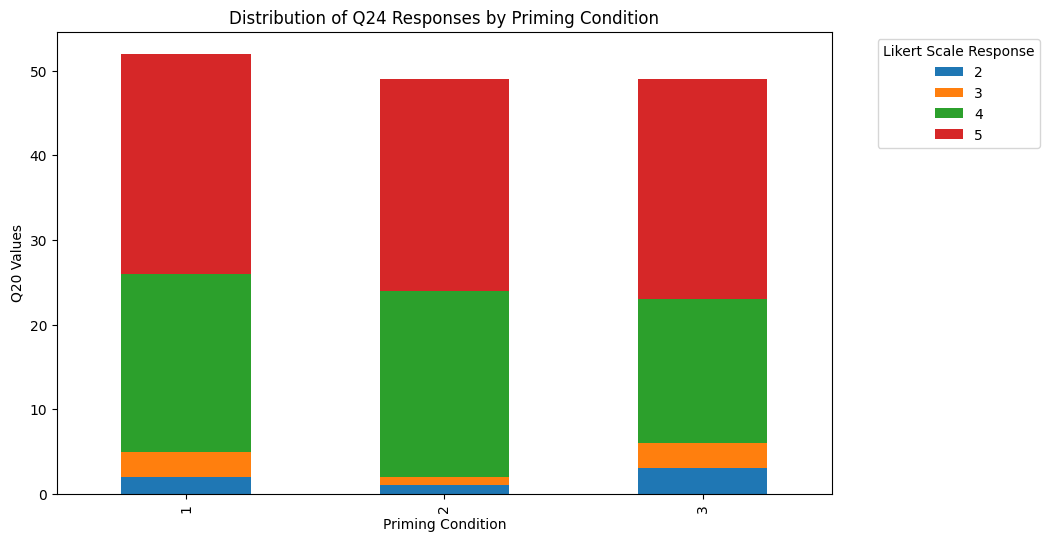

In [16]:
# Create a stacked bar chart showing distribution of responses
response_counts = combined_df.groupby(['priming', 'Q24']).size().unstack(fill_value=0)
ax = response_counts.plot(kind='bar', stacked=True, figsize=(10, 6), 
                         title='Distribution of Q24 Responses by Priming Condition')
ax.legend(title='Likert Scale Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('')  
plt.xlabel('Priming Condition')
plt.ylabel('Q20 Values')
plt.show()

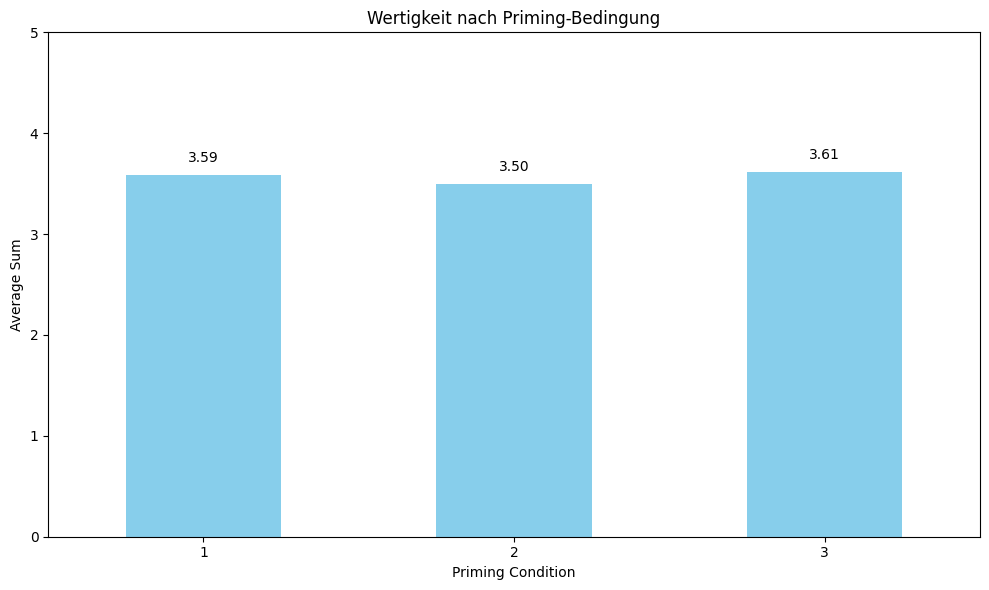

In [19]:
q_set = get_q_columns_from_v(['v_10903','v_10904','v_10905'], inverse_map)
# q_set = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']  # Example Q columns to analyze

columns_to_analyze = list(q_set)

# Calculate mean of the columns for each row, then average by priming condition
if columns_to_analyze:
    combined_df['mean_columns'] = combined_df[columns_to_analyze].mean(axis=1)
    mean_by_priming = combined_df.groupby(['priming'])['mean_columns'].mean()
    
    # Create bar chart using matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))
    mean_by_priming.plot(kind='bar', ax=ax, title='Wertigkeit nach Priming-Bedingung', color='skyblue')
    ax.set_xlabel('Priming Condition')
    ax.set_ylabel('Average Sum')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticks(range(0, 6, 1))
    
    # Add value labels on top of bars
    for i, v in enumerate(mean_by_priming.values):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No columns available for analysis")

<Figure size 1000x600 with 0 Axes>

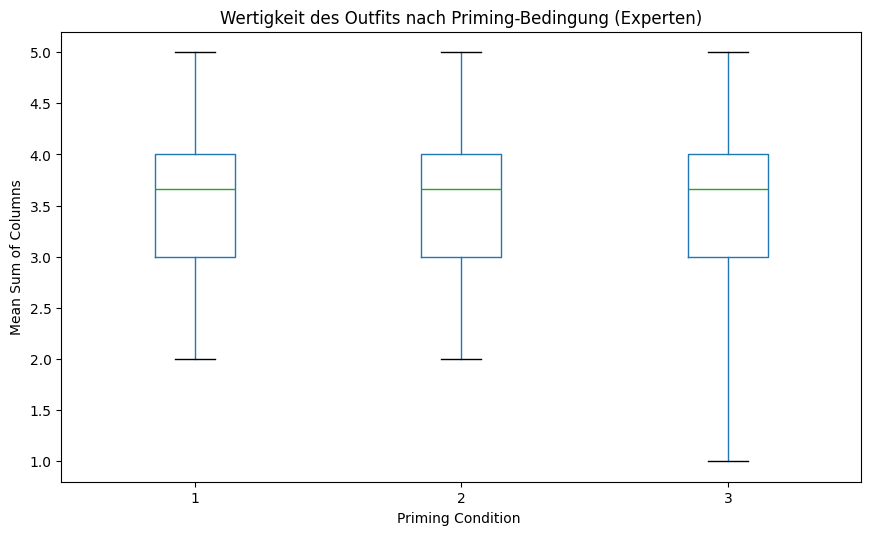

In [20]:
# Boxplot of mean_columns distribution by priming condition
plt.figure(figsize=(10, 6))
# Use pandas boxplot grouped by c_0001, whiskers to min/max to include all points
combined_df.boxplot(column='mean_columns', by='priming', grid=False, figsize=(10, 6), whis=[0,100])
plt.title('Wertigkeit des Outfits nach Priming-Bedingung (Experten)')
plt.xlabel('Priming Condition ')
plt.ylabel('Mean Sum of Columns')
plt.suptitle('')  # clear the automatic suptitle
plt.show()

### Hypothese 1

In [21]:
liking_columns = ['v_10959','v_10960','v_10961', 'v_10906','v_10907','v_10908','v_10915','v_10916','v_10917', 'v_10924','v_10925','v_10926', 'v_10933','v_10934','v_10935', 'v_10942','v_10943','v_10944', 'v_10951','v_10952','v_10953']

In [23]:
q_set = get_q_columns_from_v(liking_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['mean_liking'] = combined_df[columns_to_analyze].mean(axis=1)

for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.920, p=0.1477
Shapiro prim=3, prof=False: W=0.962, p=0.3084
Shapiro prim=2, prof=True: W=0.912, p=0.1254
Shapiro prim=2, prof=False: W=0.928, p=0.0298
Shapiro prim=1, prof=True: W=0.942, p=0.4380
Shapiro prim=1, prof=False: W=0.974, p=0.5185


In [ ]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=0.885, p=0.4927


In [ ]:
model = ols('mean_liking ~ C(priming) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA-Tabelle (Typ II):")
print(anova_table)


ANOVA-Tabelle (Typ II):
                                  sum_sq     df         F    PR(>F)
C(priming)                      1.112365    2.0  1.006551  0.368034
C(is_professional)              4.018654    1.0  7.272758  0.007836
C(priming):C(is_professional)   0.180883    2.0  0.163677  0.849174
Residual                       79.569023  144.0       NaN       NaN


In [30]:
def summarize_anova(anova_df, alpha=0.05):
    """
    Druckt eine übersichtliche Zusammenfassung der ANOVA-Ergebnisse inklusive
    Effektstärken (η²) und kurzer Interpretation.
    
    Parameter:
    - anova_df: pandas DataFrame mit Spalten ['sum_sq', 'df', 'F', 'PR(>F)']
                und Index = Effektnamen (z.B. 'Priming', 'Professionalität', 'Residual').
    - alpha:    Signifikanzniveau (Standard: 0.05).
    """
    # Effektstärke η² berechnen
    anova_df = anova_df.copy()
    anova_df['eta_sq'] = anova_df['sum_sq'] / anova_df['sum_sq'].sum()
    
    # Schwellwerte nach Cohen (Faustwerte)
    def effect_size_label(eta):
        if eta < 0.01:
            return "vernachlässigbar"
        elif eta < 0.06:
            return "klein"
        elif eta < 0.14:
            return "mittel"
        else:
            return "groß"
    
    # Ausgabe
    for name, row in anova_df.iterrows():
        if name.lower() == 'residual':
            continue  # Residual nicht interpretieren
        F = row['F']
        p = row['PR(>F)']
        eta = row['eta_sq']
        signif = "signifikant" if p < alpha else "nicht signifikant"
        size_label = effect_size_label(eta)
        
        print(f"Effekt '{name}': F({int(row['df'])}) = {F:.2f}, p = {p:.3f}, η² = {eta:.3f} ({size_label}), {signif}.")
    print(f"(α = {alpha})")

In [31]:
summarize_anova(anova_table)

Effekt 'C(priming)': F(2) = 0.07, p = 0.929, η² = 0.001 (vernachlässigbar), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 12.87, p = 0.000, η² = 0.081 (mittel), signifikant.
Effekt 'C(priming):C(is_professional)': F(2) = 0.77, p = 0.466, η² = 0.010 (vernachlässigbar), nicht signifikant.
(α = 0.05)


/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_19975/118568246.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


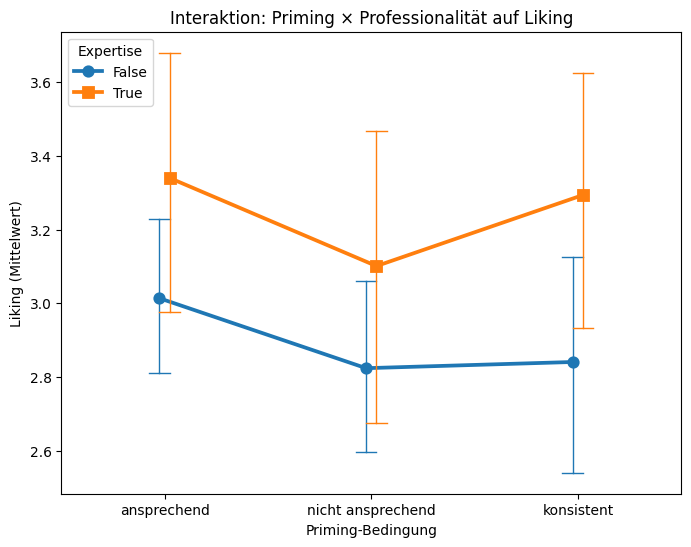

In [38]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='mean_liking', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, errwidth=1
)
plt.title('Interaktion: Priming × Professionalität auf Liking')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.xticks([0,1,2], ['ansprechend', 'nicht ansprechend', 'konsistent'])

plt.ylabel('Liking (Mittelwert)')
plt.legend(title='Expertise')
plt.show()

### Hypothese 2

In [24]:
price_columns = ['v_11376']
q_set = get_q_columns_from_v(price_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df[columns_to_analyze].describe()


,Q73
count,150.000000
mean,1101.800000
std,929.756806
min,190.000000
25%,522.750000
50%,802.500000
75%,1251.250000
max,6000.000000


In [25]:
for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)][columns_to_analyze]
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.892, p=0.0502
Shapiro prim=3, prof=False: W=0.609, p=0.0000
Shapiro prim=2, prof=True: W=0.877, p=0.0350
Shapiro prim=2, prof=False: W=0.830, p=0.0001
Shapiro prim=1, prof=True: W=0.729, p=0.0008
Shapiro prim=1, prof=False: W=0.781, p=0.0000


In [26]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['Q73']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=2.085, p=0.0706


In [27]:
model = ols('Q73 ~ C(priming) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA-Tabelle (Typ II):")
print(anova_table)


ANOVA-Tabelle (Typ II):
                                     sum_sq     df          F    PR(>F)
C(priming)                     1.198595e+05    2.0   0.073802  0.928891
C(is_professional)             1.044951e+07    1.0  12.868293  0.000457
C(priming):C(is_professional)  1.245154e+06    2.0   0.766687  0.466436
Residual                       1.169332e+08  144.0        NaN       NaN


In [32]:
summarize_anova(anova_table)

Effekt 'C(priming)': F(2) = 0.07, p = 0.929, η² = 0.001 (vernachlässigbar), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 12.87, p = 0.000, η² = 0.081 (mittel), signifikant.
Effekt 'C(priming):C(is_professional)': F(2) = 0.77, p = 0.466, η² = 0.010 (vernachlässigbar), nicht signifikant.
(α = 0.05)


/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_19975/3446993545.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


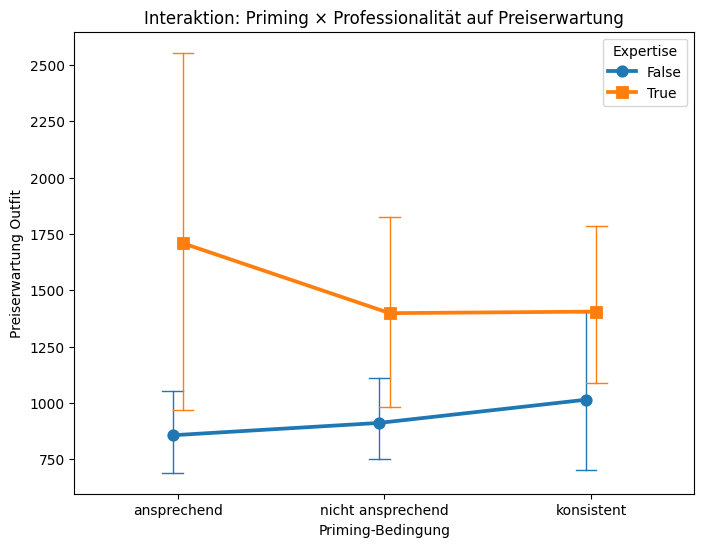

In [37]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='Q73', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, errwidth=1
)
plt.title('Interaktion: Priming × Professionalität auf Preiserwartung')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.ylabel('Preiserwartung Outfit')
plt.xticks([0,1,2], ['ansprechend', 'nicht ansprechend', 'konsistent'])
plt.legend(title='Expertise')
plt.show()